<a href="https://colab.research.google.com/github/kishanshah98/fedfunds/blob/main/FedFundsPredictionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federal Funds Rate Prediction

## Neural Network Selection

**Why RNN?**

Since this is a time series model application, I want to use a RNN (Recurrent Neural Network) for this problem due to its ability to process sequential information and ability to maintain context across time steps. RNNs also have a memory that allow them to store information about past inputs and use it to inform future predictions, which is required of this model. CNNs process data in parallel, which can be efficient for image and spatial data but less suitable for sequential data where the order of information is crucial. RNNs, on the other hand, process data sequentially, allowing them to capture the temporal dependencies between data points.

**Why LSTM?**

Standard RNNs suffer from the vanishing gradient problem, where gradients become smaller and smaller as they are backpropagated through time steps. This makes it difficult for the network to learn long-term dependencies. LSTMs mitigate this issue using a sophisticated cell state that can store information over long periods, ensuring that gradients can flow effectively. LSTMs have "gates" that control the flow of information into and out of the cell state. This allows the network to selectively remember relevant information and forget irrelevant details. This selective memory mechanism is crucial for capturing complex patterns in economic data, which often involves long-term trends and short-term fluctuations. In numerous studies and real-world applications, LSTMs have consistently outperformed vanilla RNNs in time series forecasting tasks, including financial time series like the Fed Funds rate.

## Code

### Connect with google drive to access data and import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.dates as mdates

### Loading the federal funds effective rates data and data preprocessing

In [ ]:
# Load the data
df_int_rates = pd.read_csv('/content/drive/My Drive/FEDFUNDS.csv')

# Convert 'DATE' columns to datetime
df_int_rates['DATE'] = pd.to_datetime(df_int_rates['DATE'])

# Add the new data point for November 2024
new_data_point = pd.DataFrame({
    'DATE': ['2024-11-01'],
    'FEDFUNDS': [4.58]
})

# Convert the 'DATE' column to datetime
new_data_point['DATE'] = pd.to_datetime(new_data_point['DATE'])

# Concatenate the new data point into the existing dataframe
df_int_rates_new = pd.concat([df_int_rates, new_data_point], ignore_index=True)

# Sort the dataframe by the 'DATE' column to ensure chronological order
df_int_rates_new = df_int_rates_new.sort_values('DATE').reset_index(drop=True)
print(df_int_rates_new)

# Summary of the interest rate data
df_int_rates_new.info()
df_int_rates_new.describe()

          DATE  FEDFUNDS
0   1954-07-01      0.80
1   1954-08-01      1.22
2   1954-09-01      1.07
3   1954-10-01      0.85
4   1954-11-01      0.83
..         ...       ...
840 2024-07-01      5.33
841 2024-08-01      5.33
842 2024-09-01      5.13
843 2024-10-01      4.83
844 2024-11-01      4.58

[845 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATE      845 non-null    datetime64[ns]
 1   FEDFUNDS  845 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.3 KB


,DATE,FEDFUNDS
count,845,845.000000
mean,1989-08-31 10:11:47.218934912,4.609432
min,1954-07-01 00:00:00,0.050000
25%,1972-02-01 00:00:00,1.820000
50%,1989-09-01 00:00:00,4.270000
75%,2007-04-01 00:00:00,6.170000
max,2024-11-01 00:00:00,19.100000
std,NaN,3.569702


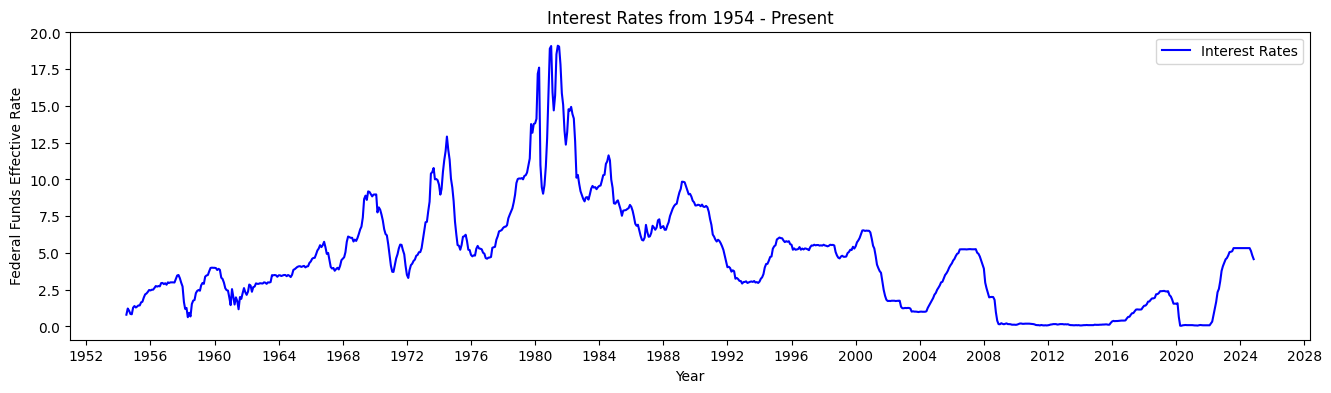

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up the figure and plot
plt.figure(figsize=(16, 4))
plt.plot(df_int_rates_new['DATE'], df_int_rates_new['FEDFUNDS'], color='blue', label='Interest Rates')
plt.xlabel('Year')
plt.ylabel('Federal Funds Effective Rate')
plt.title('Interest Rates from 1954 - Present')

# Format x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=4))  # Show every 4th year

plt.legend()
plt.show()

### Introducing and loading job openings data to test relationship between the two - Jobs Data & Interest Rates

In [ ]:
df_jobs = pd.read_csv('/content/drive/My Drive/JobOpenings.csv')
print(df_jobs)

# Summary of the job openings data
df_jobs.info()
df_jobs.describe()

           DATE  JTSJOL
0    2000-12-01    5088
1    2001-01-01    5234
2    2001-02-01    5097
3    2001-03-01    4762
4    2001-04-01    4615
..          ...     ...
281  2024-05-01    8230
282  2024-06-01    7910
283  2024-07-01    7711
284  2024-08-01    7861
285  2024-09-01    7443

[286 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    286 non-null    object
 1   JTSJOL  286 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ KB


,JTSJOL
count,286.000000
mean,5397.241259
std,2325.384019
min,2232.000000
25%,3701.000000
50%,4630.000000
75%,6679.500000
max,12182.000000


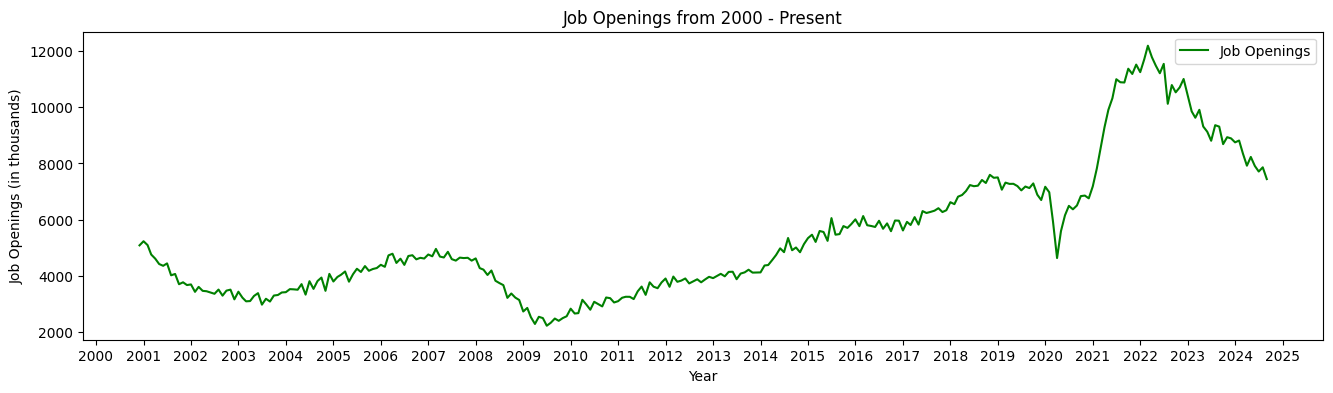

In [ ]:
df_jobs['DATE'] = pd.to_datetime(df_jobs['DATE'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up the figure and plot
plt.figure(figsize=(16, 4))
plt.plot(df_jobs['DATE'], df_jobs['JTSJOL'], color='green', label='Job Openings')
plt.xlabel('Year')
plt.ylabel('Job Openings (in thousands)')
plt.title('Job Openings from 2000 - Present')

# Format x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))

plt.legend()
plt.show()

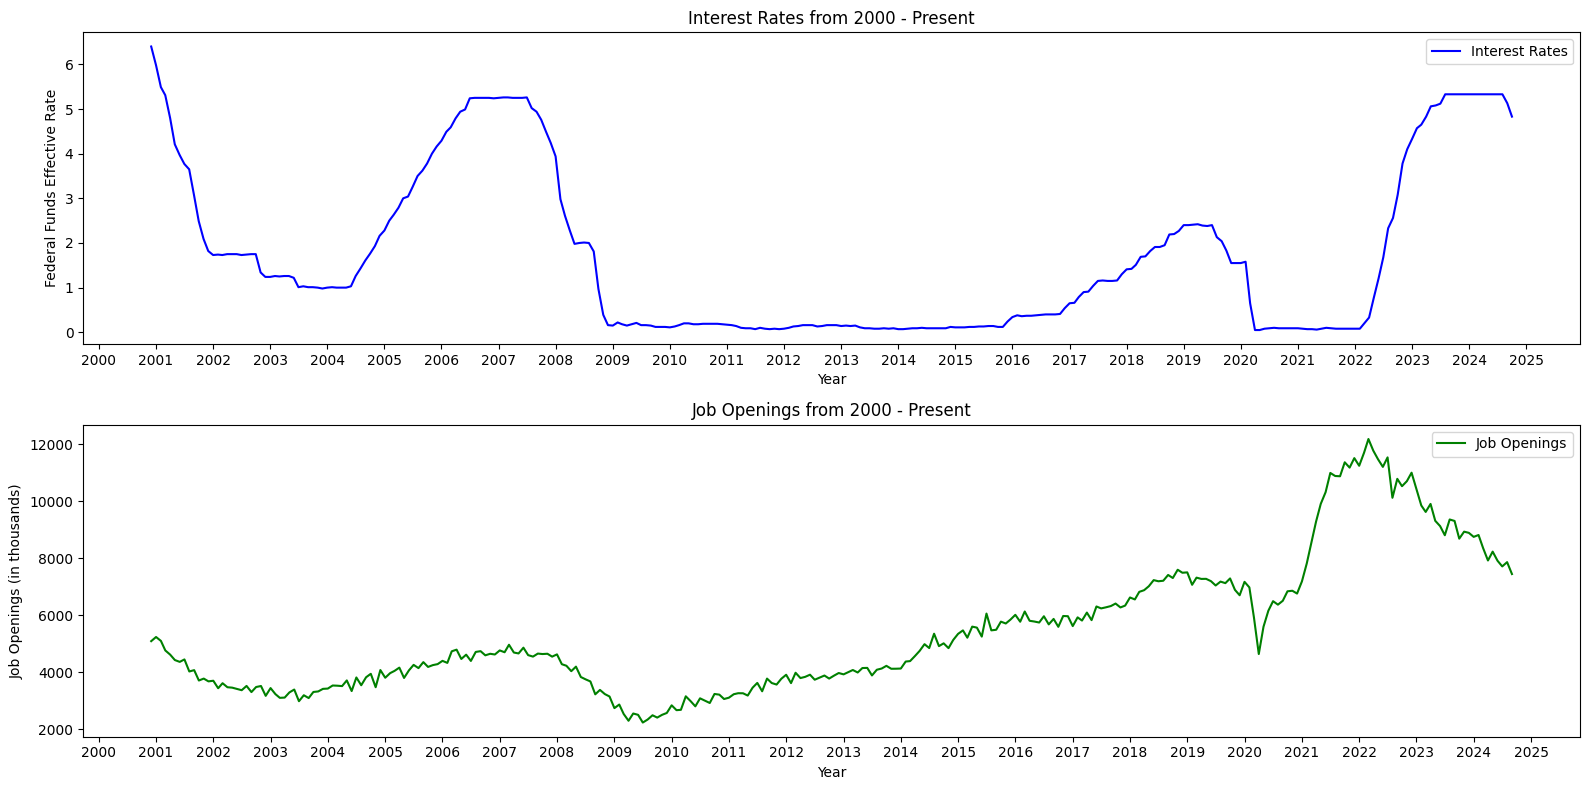

In [ ]:
df_int_rates_2000 = df_int_rates[df_int_rates['DATE'] >= '2000-12-01']

# Create a 2x1 subplot grid (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

# Plot Interest Rates in the first subplot
ax[0].plot(df_int_rates_2000['DATE'], df_int_rates_2000['FEDFUNDS'], color='blue', label='Interest Rates')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Federal Funds Effective Rate')
ax[0].set_title('Interest Rates from 2000 - Present')
ax[0].xaxis.set_major_locator(mdates.YearLocator(base=1))  # Show every 4th year on x-axis
ax[0].legend()

# Plot Job Openings in the second subplot
ax[1].plot(df_jobs['DATE'], df_jobs['JTSJOL'], color='green', label='Job Openings')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Job Openings (in thousands)')
ax[1].set_title('Job Openings from 2000 - Present')
ax[1].xaxis.set_major_locator(mdates.YearLocator(base=1))  # Show every 4th year on x-axis
ax[1].legend()

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


In [ ]:
# Merge datasets on 'DATE'
df = pd.merge(df_int_rates_new, df_jobs, on='DATE', how='inner')

print(df[['FEDFUNDS', 'JTSJOL']].corr())

          FEDFUNDS    JTSJOL
FEDFUNDS  1.000000  0.207074
JTSJOL    0.207074  1.000000


Initially, I attempted to include the job openings data (JTSJOL) in the model, hoping it might enhance the predictions for the FEDFUNDS rate. However, after analyzing the results, I found that the correlation between the two variables is quite low (0.207), indicating a weak linear relationship. This minimal correlation suggests that job openings data does not provide significant predictive value for forecasting the Federal Funds Rate. As a result, adding this data introduced unnecessary complexity and noise, ultimately leading to worse model performance. Given these findings, I decided to exclude the job openings data from the model and focus solely on the FEDFUNDS rate, which has demonstrated better predictive accuracy.

### Normalize the Fed Funds Rates dataset being used for the actual model

In [ ]:
# Normalize the FEDFUNDS column using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_int_rates_new[['FEDFUNDS']])

### Building the LSTM Model

In [ ]:
# Create sequences of data for LSTM
def create_dataset(dataset, look_back=36):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Use a look_back period of 36 months
look_back = 36
X, y = create_dataset(scaled_data, look_back)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data to be compatible with LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


This code prepares data for training an LSTM neural network by creating sequences of time-series data. The create_dataset function generates sliding windows of input sequences (dataX) and corresponding target values (dataY). For each sequence, the function extracts look_back consecutive time steps (36 months in this case) as input and the next value as the target. After generating the sequences, the data is split into training and testing sets, with 80% of the data allocated for training. Finally, the input data is reshaped into a 3D format (samples, time steps, features), which is required for LSTM models. This structure allows the LSTM to learn temporal patterns from the sequences effectively.

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(LSTM(16, return_sequences=False, activation='relu'))

model.add(Dense(units=1))  # Output layer for prediction

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 36, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,505 (29.32 KB)

 Trainable params: 7,505 (29.32 KB)

 Non-trainable params: 0 (0.00 B)


This LSTM model begins with an LSTM layer designed to learn the temporal dependencies in sequential data. The first layer has 32 units, which determines the number of neurons in the hidden state of the LSTM, allowing it to capture complex patterns. The input_shape parameter is set to (X_train.shape[1], X_train.shape[2]), which specifies the shape of the input data — essentially the number of time steps and features at each time step in your dataset. By setting return_sequences=True, this layer outputs the full sequence at each time step rather than just the final output, allowing the next LSTM layer to receive the entire sequence as input rather than a single value. The use of ReLU activation in this layer helps the model learn non-linear relationships in the data while avoiding the vanishing gradient problem, which can slow down learning.

Following the first LSTM layer, a second LSTM layer is added with 16 units. This layer has return_sequences=False, meaning it outputs only the final state (the last time step) of the sequence, which is suitable when you're making predictions based on the entire sequence's learned information. The ReLU activation again ensures that the network can learn non-linear patterns and is computationally efficient. This second layer effectively reduces the complexity of the model while still maintaining its ability to learn patterns from the sequence.

Finally, the Dense output layer is used with a single neuron (units=1) because the model is solving a regression problem — predicting a continuous numerical value, such as the Fed Funds Rate. Since it's a regression task, no activation function is applied to the output layer, allowing the model to produce any real-valued output that corresponds to the prediction.

In summary, this model architecture is designed to capture complex sequential dependencies with two LSTM layers (with ReLU activations), followed by a Dense layer for continuous output. This setup is ideal for time-series forecasting tasks like predicting the Fed Funds Rate.

In [ ]:
# Compile the model with an optimizer (e.g., Adam) and loss function (MSE)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and store history
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and true values to get them back to the original scale
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 1)))))[:, 0]
y_test = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1)))))[:, 0]

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0759 - val_loss: 0.0133
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0097 - val_loss: 0.0047
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0069 - val_loss: 0.0028
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0050 - val_loss: 0.0016
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0055 - val_loss: 0.0013
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0045 - val_loss: 9.9138e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss:

This code first compiles the LSTM model by specifying an optimizer and a loss function. The optimizer used is Adam, which is a popular choice for training neural networks due to its adaptive learning rate, helping the model converge faster and more efficiently. The loss function is mean squared error, which is commonly used for regression tasks as it penalizes large errors more heavily. The model is then trained on the training data X_train, y_train for 50 epochs, with a batch size of 16, meaning the model will update its weights after processing 16 samples at a time. After training, the model makes predictions on the test set X_test. The predictions and true values are then inverse-transformed using the scaler.inverse_transform function. This step is crucial as the model likely operated on scaled data, so the inverse transformation converts the predictions and true values back to the original scale of the target variable. The final result is a set of predictions that can be compared to the actual values to evaluate the model's performance.

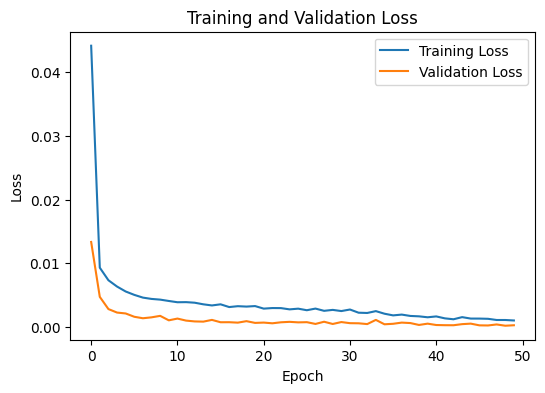

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE, MAE, and R²
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 0.2813
MAE: 0.2108
R²: 0.9742


This code calculates three evaluation metrics: RMSE, MAE, and R² to assess the model's performance. RMSE measures the average magnitude of errors, MAE gives the average absolute difference between predicted and actual values, and R² shows how well the model explains the variance in the data. The results are printed with four decimal places for each metric.

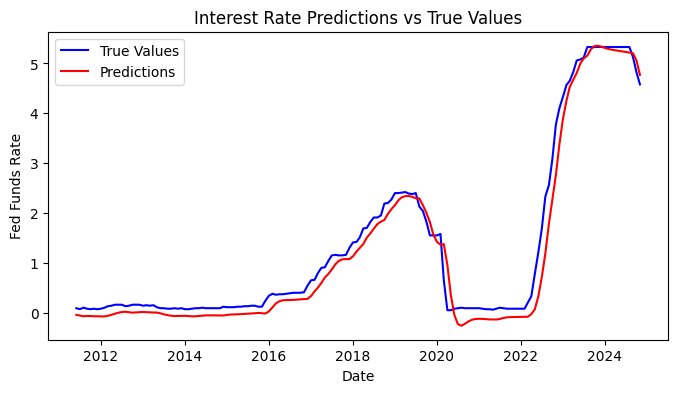

In [ ]:
# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(df_int_rates_new['DATE'].iloc[train_size + look_back:], y_test, color='blue', label='True Values')
plt.plot(df_int_rates_new['DATE'].iloc[train_size + look_back:], predictions, color='red', label='Predictions')
plt.title('Interest Rate Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.legend()
plt.show()

### Future Predictions

In [ ]:
# Forecast the next 5 months (December 2024 to April 2025)
last_sequence = X_test[-1].reshape(1, look_back, X_test.shape[2])

# Generate predictions for the next 5 months (December 2024 to April 2025)
future_predictions = []
for _ in range(5):
    next_pred = model.predict(last_sequence)[0, 0]
    future_predictions.append(next_pred)

    # Shift and insert new prediction
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_pred

# Inverse transform the predictions to get the actual FEDFUNDS values
future_predictions_scaled = np.hstack((np.array(future_predictions).reshape(-1, 1), np.zeros((len(future_predictions), 1))))
future_predictions = scaler.inverse_transform(future_predictions_scaled)[:, 0]

# Create date range for future predictions (December 2024 to April 2025)
future_dates = pd.date_range(start='2024-12-01', periods=5, freq='MS')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


This code forecasts the next 5 months of interest rate data (from December 2024 to April 2025) using a trained LSTM model. It starts by taking the last sequence of test data (X_test[-1]) and reshaping it to match the expected input shape for the model. Then, for each of the next 5 months, the model generates a prediction (next_pred) and appends it to the future_predictions list. After each prediction, the sequence is updated by shifting it and inserting the new prediction into the sequence, making it ready for the next prediction. Once all predictions are generated, the results are inverse-transformed to bring them back to their original scale (i.e., actual interest rate values) using the fitted scaler. Finally, a date range for the next 5 months (from December 2024 to April 2025) is created using pd.date_range, aligning the predicted values with these future dates.

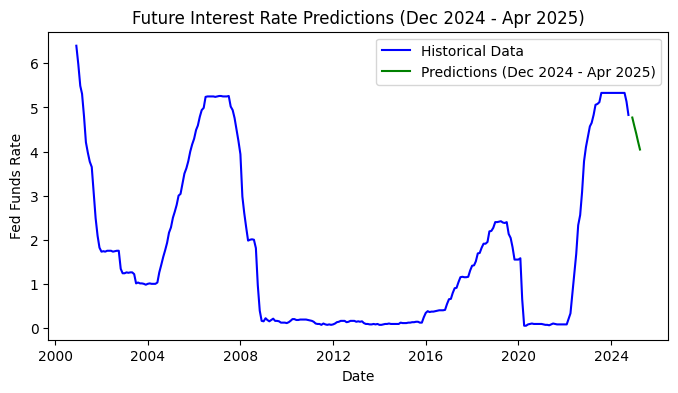

In [ ]:
# Plot future predictions
plt.figure(figsize=(8, 4))
plt.plot(df_int_rates_2000['DATE'], df_int_rates_2000['FEDFUNDS'], color='blue', label='Historical Data')
plt.plot(future_dates, future_predictions, color='green', label='Predictions (Dec 2024 - Apr 2025)')
plt.title('Future Interest Rate Predictions (Dec 2024 - Apr 2025)')
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.legend()
plt.show()

In [ ]:
# Print future predictions for December 2024 to April 2025
print("Predicted interest rates (FEDFUNDS) from Dec 2024 to Apr 2025:")
for date, prediction in zip(future_dates, future_predictions):
    print(f"{date.strftime('%b %Y')}: {prediction:.4f}")

Predicted interest rates (FEDFUNDS) from Dec 2024 to Apr 2025:
Dec 2024: 4.7713
Jan 2025: 4.5851
Feb 2025: 4.4073
Mar 2025: 4.2293
Apr 2025: 4.0459


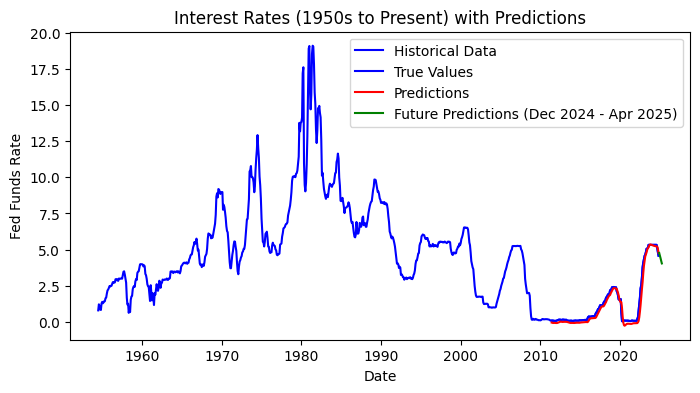

In [ ]:
# Plot the historical data along with predictions (including the future predictions)
plt.figure(figsize=(8, 4))

# Plot historical data (from 1950s to the present)
plt.plot(df_int_rates_new['DATE'], df_int_rates_new['FEDFUNDS'], color='blue', label='Historical Data')

# Plot true values from the test set
plt.plot(df_int_rates_new['DATE'].iloc[train_size + look_back:], y_test, color='blue', label='True Values')

# Plot predictions from the test set
plt.plot(df_int_rates_new['DATE'].iloc[train_size + look_back:], predictions, color='red', label='Predictions')

# Plot future predictions (December 2024 to Apr 2025)
plt.plot(future_dates, future_predictions, color='green', label='Future Predictions (Dec 2024 - Apr 2025)')

# Add titles and labels
plt.title('Interest Rates (1950s to Present) with Predictions')
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.legend()